# ResNet34 pretrained on ImageNet and fully fine-tuned on CIFAR10

In [1]:
from torchvision import datasets
import torchvision
from torchvision.transforms import ToTensor
from torchvision.models import resnet34, ResNet34_Weights
import torch
from tqdm.notebook import tqdm
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# Hyperparameters
batch_size = 256
ce_loss = nn.CrossEntropyLoss()
learning_rate = 0.0001
weight_decay = 0.0001
momentum = 0.0
epoch = 25

## CIFAR-10 Dataset

In [3]:
# Download traning and test data from open datasets --- MNIST
def cifar10():
    training_data = datasets.CIFAR10(
        root="data",
        train=True,
        download=True,
        transform=torchvision.transforms.Compose([
        # Resize step is required as we will use a ResNet model, which accepts at leats 224x224 images
          torchvision.transforms.Resize((224,224)),
          torchvision.transforms.ToTensor(),
        ])
    )

    test_data = datasets.CIFAR10(
        root='data',
        train=False,
        download=True,
        transform=torchvision.transforms.Compose([
        # Resize step is required as we will use a ResNet model, which accepts at leats 224x224 images
          torchvision.transforms.Resize((224,224)),
          torchvision.transforms.ToTensor(),
        ])
    )

    num_classes = 10
    return training_data, test_data, num_classes

In [4]:
#gpu
device = 'cuda' if torch.cuda.is_available() else "cpu"
print("Using {} device \n".format(device))

# Dataloader
training_data, test_data, NUM_CLASSES = cifar10()
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

Using cuda device 



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


## Model

In [5]:
model = resnet34(weights=ResNet34_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad=False
model.fc = nn.Linear(512, 10)
# torch.nn.init.xavier_uniform_(model.fc.weight)
model = model.to(device)
# preprocess = model.transforms()
# img_transformed = preprocess(img)


In [6]:
# model = ResNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=0, min_lr=1e-4)

In [7]:
# Accuracy
def accuracy(y_pred, target):
    train_acc = torch.sum(torch.argmax(y_pred, dim=1) == target)
    final_train_acc = train_acc/target.shape[0]
    return final_train_acc * 100

In [8]:
all_train_losses=[]
all_test_losses=[]
all_train_accuracy=[]
all_test_accuracy=[]

In [9]:
def train():
    cur_step = 0
    for features, label in train_dataloader:
        logits = model(features.to(device))
        label = label.to(device)

        loss = ce_loss(logits, label)
        accuracy_batch = accuracy(logits, label)
        all_train_losses.append(loss.item())
        all_train_accuracy.append(accuracy_batch.item())

        optimizer.zero_grad()
        loss.backward()
        if cur_step % 10 == 0:
           print('\033[32m' + f"Step = {cur_step}, Train Loss = {loss:.3f}, Train Accuracy = {accuracy_batch:.2f}%" + '\033[0m')
        optimizer.step()
        cur_step += 1

In [10]:
def test():
    model.eval()
    total_loss = 0
    total_accuracy = 0
    step = 0

    for features, label in test_dataloader:
        with torch.no_grad():
            logits = model(features.to(device))
            label = label.to(device)
            loss = ce_loss(logits, label)
            total_loss += loss.item()
            accuracy_batch = accuracy(logits, label)
            total_accuracy += accuracy_batch.item()
            step += 1
    total_loss = total_loss / step
    total_accuracy = total_accuracy /step

    all_test_losses.append(total_loss)
    all_test_accuracy.append(total_accuracy)
    print('\033[31m' + f"Test Loss = {total_loss:.3f}, Test Accuracy = {total_accuracy:.2f}%" + '\033[0m')
    model.train()
    return total_loss

In [11]:
for i in tqdm(range(epoch)):
    print()
    print('\033[34m' + f"Epoch {i+1}" + '\033[0m')
    train()
    test_loss = test()
    scheduler.step(test_loss)
    print(f"Learning Rate = {optimizer.param_groups[0]['lr']}")

  0%|          | 0/25 [00:00<?, ?it/s]


Epoch 1


Step = 0, Train Loss = 2.554, Train Accuracy = 7.81%
Step = 10, Train Loss = 2.373, Train Accuracy = 8.98%
Step = 20, Train Loss = 2.333, Train Accuracy = 13.67%
Step = 30, Train Loss = 2.293, Train Accuracy = 14.84%
Step = 40, Train Loss = 2.253, Train Accuracy = 15.23%
Step = 50, Train Loss = 2.195, Train Accuracy = 18.36%
Step = 60, Train Loss = 2.119, Train Accuracy = 25.39%
Step = 70, Train Loss = 2.104, Train Accuracy = 25.78%
Step = 80, Train Loss = 2.064, Train Accuracy = 30.47%
Step = 90, Train Loss = 1.998, Train Accuracy = 36.33%
Step = 100, Train Loss = 1.970, Train Accuracy = 36.33%
Step = 110, Train Loss = 1.891, Train Accuracy = 44.14%
Step = 120, Train Loss = 1.885, Train Accuracy = 41.80%
Step = 130, Train Loss = 1.853, Train Accuracy = 41.41%
Step = 140, Train Loss = 1.801, Train Accuracy = 41.02%
Step = 150, Train Loss = 1.780, Train Accuracy = 46.09%
Step = 160, Train Loss = 1.732, Train Accuracy = 50.00%
Step = 170, Train Loss = 1.760, Train Accuracy = 47.27%
Step 

KeyboardInterrupt: 

In [12]:
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

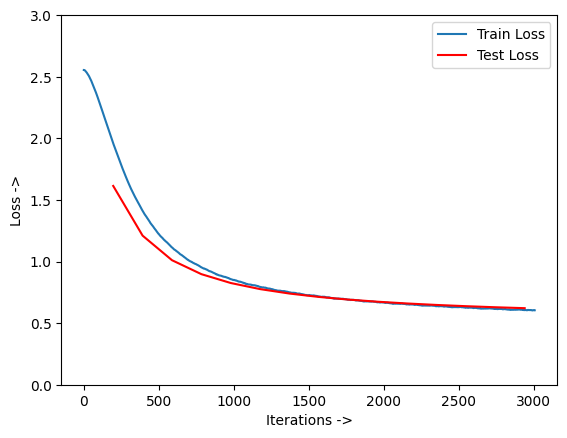

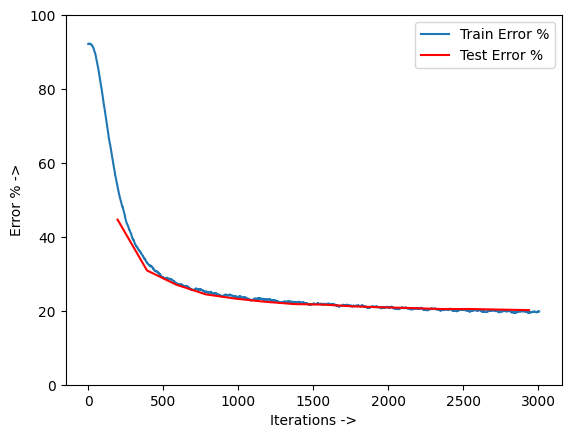

In [15]:
import numpy as np
plt.plot(smooth(all_train_losses, 0.99), label='Train Loss')
steps_per_epoch = len(train_dataloader)
test_iterations = [steps_per_epoch*(i+1) for i in range(15)]
plt.plot(test_iterations, all_test_losses, label='Test Loss', color='red')
plt.ylim([0, 3.0])
plt.xlabel('Iterations ->')
plt.ylabel('Loss ->')
plt.legend()
plt.show()

all_train_error = 100 - np.array(all_train_accuracy)
all_test_error = 100 - np.array(all_test_accuracy)
plt.plot(smooth(all_train_error, 0.98), label='Train Error %')
plt.plot(test_iterations, all_test_error, label='Test Error %', color='red')
plt.xlabel('Iterations ->')
plt.ylabel('Error % ->')
plt.ylim([0, 100])
plt.legend()
plt.show()

In [ ]:
from torchinfo import summary
summary(model, input_size=(batch_size, 3, 32, 32))
